1. Explore dataset – correlation between features, their impact on target, independence assumptions
2. Try multiple visualization strategies: correlation plots, dimensionality reduction approaches – PCA, UMAP, t-SNE. Explain gained insights
3. Explore data using unsupervised learning techniques
4. Identify appropriate cross-validation strategy
5. Train a simple model first. Use validation set for hyperparameter tuning and/or early stopping. Analyze its performance using cross-validation. Identify potential pitfalls.
6. Propose ways to improve performance – e.g., feature selection, regularization, increasing model complexity. Conduct at least 2 more experiments


In [1]:
!pip install umap-learn


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, pearsonr
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import umap

In [3]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')

data.info()
# data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
# print(data.isnull().sum())
# data.info()
# data['bmi'] = data['bmi'].replace(to_replace=np.nan, value=data['bmi'].mean())
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(data[numeric_columns])  # Apply to only numeric columns

# Convert back to DataFrame and update the original data
data_imputed = pd.DataFrame(data_imputed, columns=numeric_columns)
data[numeric_columns] = data_imputed
# data.isnull().sum()
X = data.drop(columns=['stroke'])  # Drop the target column 'stroke' from features
y = data['stroke'] 

print(X.isna())
# y.head()

         id  gender    age  hypertension  heart_disease  ever_married  \
0     False   False  False         False          False         False   
1     False   False  False         False          False         False   
2     False   False  False         False          False         False   
3     False   False  False         False          False         False   
4     False   False  False         False          False         False   
...     ...     ...    ...           ...            ...           ...   
5105  False   False  False         False          False         False   
5106  False   False  False         False          False         False   
5107  False   False  False         False          False         False   
5108  False   False  False         False          False         False   
5109  False   False  False         False          False         False   

      work_type  Residence_type  avg_glucose_level    bmi  smoking_status  
0         False           False              Fa

C:\Users\vk211\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\vk211\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\vk211\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\vk211\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

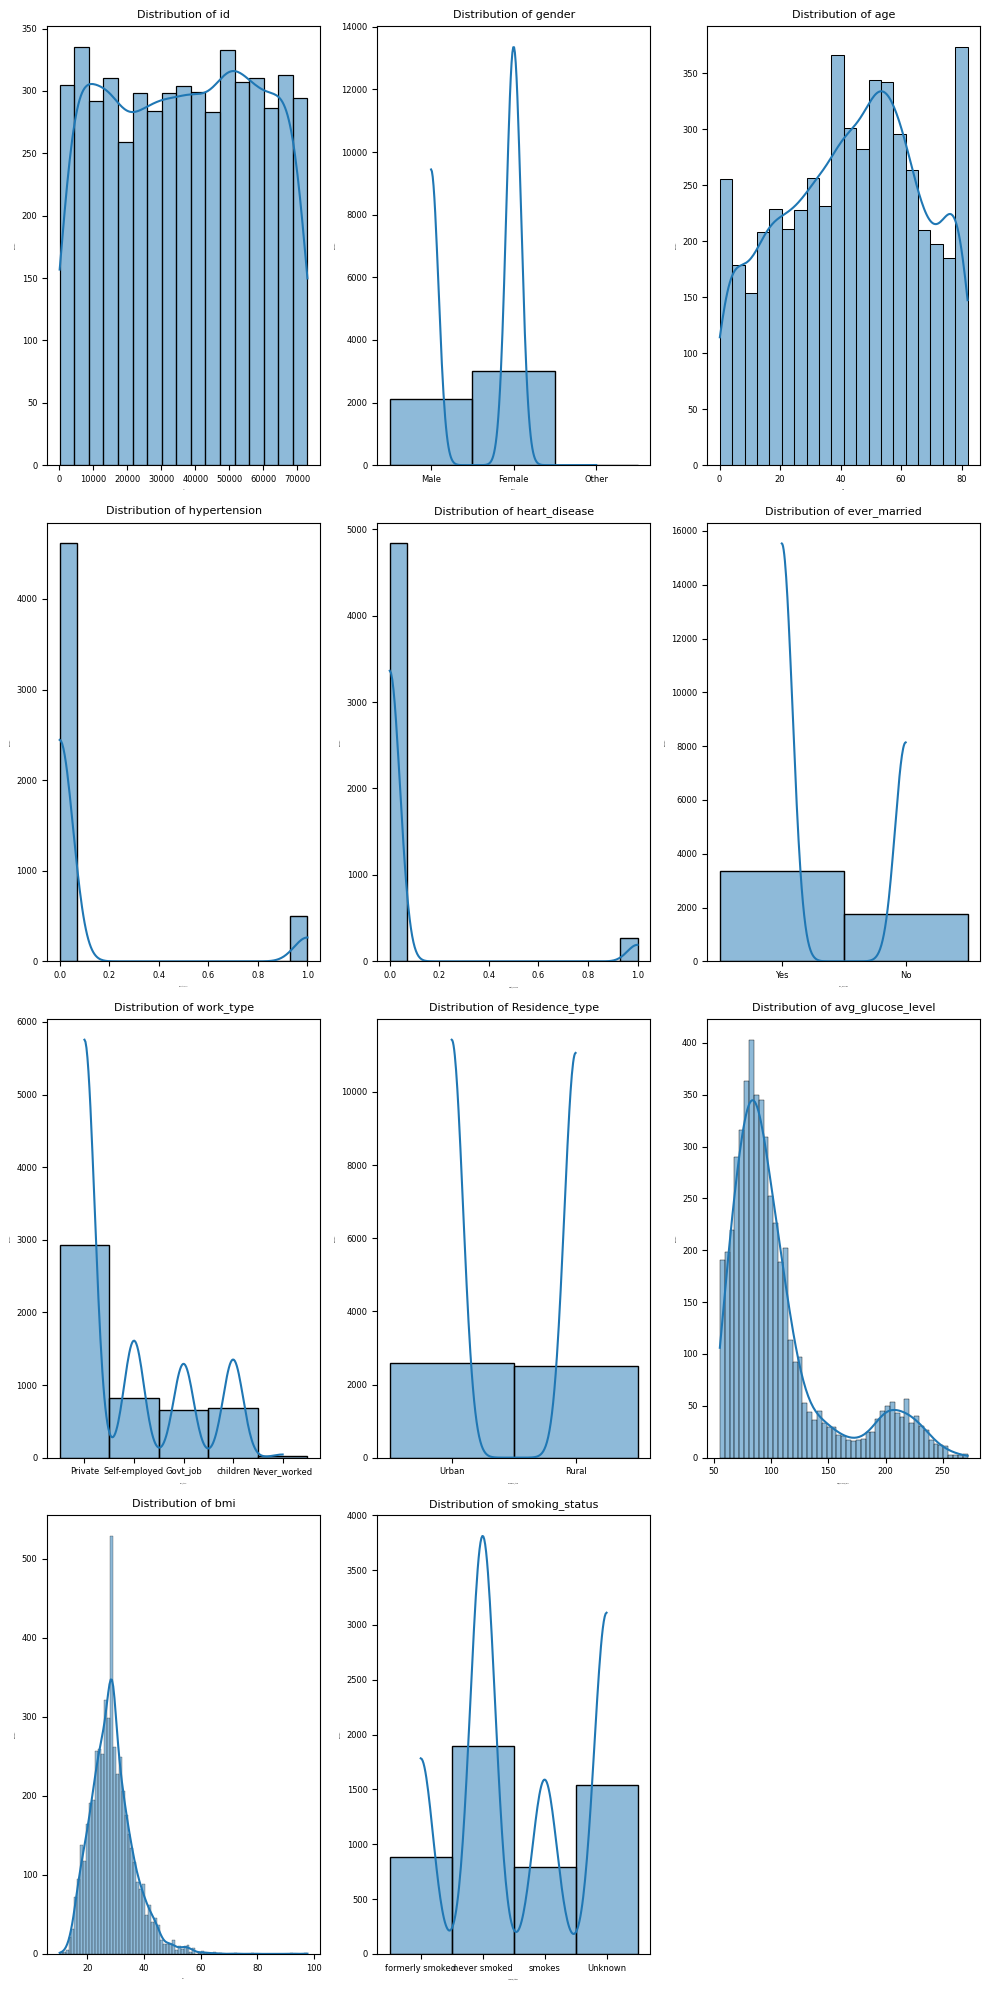

In [5]:
# Exploring distribution of the data
num_features = X.shape[1]
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols  # Calculates rows to fit all features

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 20))
axes = axes.flatten()

# Plot each feature
for i, column in enumerate(X.columns):
    sns.histplot(X[column], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {column}', fontsize=8)
    axes[i].set_xlabel(column, fontsize=0)
    axes[i].set_ylabel('Frequency', fontsize=0)
    axes[i].tick_params(axis='both', labelsize=6)

# Hide any extra subplots if there are fewer than rows * cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

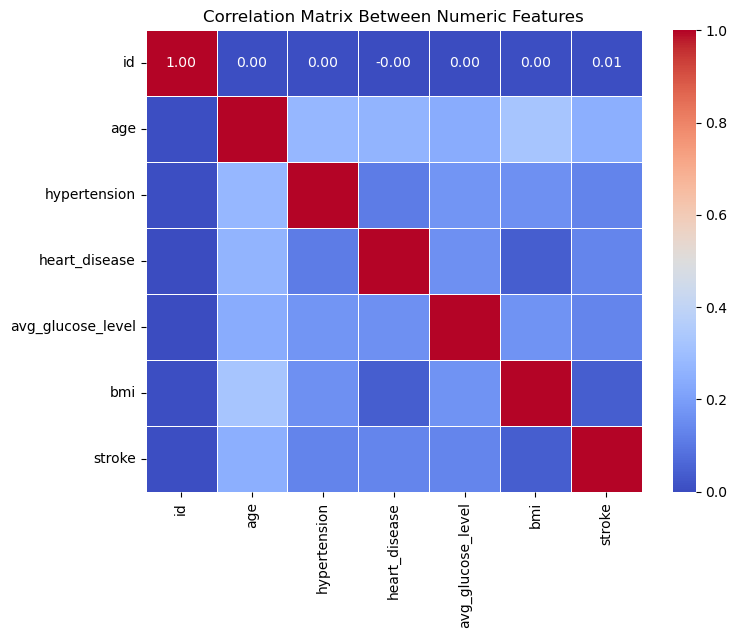

In [6]:
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
correlation_matrix = data[numeric_columns].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix Between Numeric Features")
plt.show()

In [7]:
# Analyze feature impact on target ('stroke') using Chi-square test for categorical features
impact_results = {}
for column in ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']:
    contingency_table = pd.crosstab(data[column], data['stroke'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    impact_results[column] = p

print("P-values for each feature's impact on the target ('stroke'):")
for feature, p_value in impact_results.items():
    print(f"{feature}: p-value = {p_value:.4f}")

P-values for each feature's impact on the target ('stroke'):
gender: p-value = 0.7895
hypertension: p-value = 0.0000
heart_disease: p-value = 0.0000
ever_married: p-value = 0.0000
work_type: p-value = 0.0000
Residence_type: p-value = 0.2983
smoking_status: p-value = 0.0000


In [8]:
# 3. Independence assumptions using Chi-square for feature pairs
independence_results = {}
for i, column1 in enumerate(['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']):
    for column2 in ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'][i+1:]:
        contingency_table = pd.crosstab(data[column1], data[column2])
        chi2, p, _, _ = chi2_contingency(contingency_table)
        independence_results[(column1, column2)] = p

# Display the p-values for independence tests between feature pairs
print("\nP-values for independence tests between feature pairs:")
for (feature1, feature2), p_value in independence_results.items():
    print(f"Between {feature1} and {feature2}: p-value = {p_value:.4f}")


P-values for independence tests between feature pairs:
Between gender and hypertension: p-value = 0.2998
Between gender and heart_disease: p-value = 0.0000
Between gender and ever_married: p-value = 0.0377
Between gender and work_type: p-value = 0.0000
Between gender and Residence_type: p-value = 0.5425
Between gender and smoking_status: p-value = 0.0000
Between hypertension and heart_disease: p-value = 0.0000
Between hypertension and ever_married: p-value = 0.0000
Between hypertension and work_type: p-value = 0.0000
Between hypertension and Residence_type: p-value = 0.6041
Between hypertension and smoking_status: p-value = 0.0000
Between heart_disease and ever_married: p-value = 0.0000
Between heart_disease and work_type: p-value = 0.0000
Between heart_disease and Residence_type: p-value = 0.8736
Between heart_disease and smoking_status: p-value = 0.0000
Between ever_married and work_type: p-value = 0.0000
Between ever_married and Residence_type: p-value = 0.6759
Between ever_married

In [9]:
#new code by vk211

In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Load the data
data = pd.read_csv('healthcare-dataset-stroke-data.csv')

# Drop 'id' column as it's not relevant for prediction
data = data.drop('id', axis=1)

# Convert categorical variables to numeric
data['gender'] = data['gender'].map({'Male': 0, 'Female': 1, 'Other': 2})
data['ever_married'] = data['ever_married'].map({'No': 0, 'Yes': 1})
data['Residence_type'] = data['Residence_type'].map({'Rural': 0, 'Urban': 1})

# Use pd.get_dummies() for 'work_type' and 'smoking_status'
work_type_dummies = pd.get_dummies(data['work_type'], prefix='work', drop_first=True)
smoking_status_dummies = pd.get_dummies(data['smoking_status'], prefix='smoking', drop_first=True)

# Drop original columns and concatenate dummy variables
data = data.drop(['work_type', 'smoking_status'], axis=1)
data = pd.concat([data, work_type_dummies, smoking_status_dummies], axis=1)

# Handle missing values
imputer = SimpleImputer(strategy='mean')
data['bmi'] = imputer.fit_transform(data[['bmi']])

# Split features and target
X = data.drop('stroke', axis=1)
y = data['stroke']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Shape of X_train_scaled:", X_train_scaled.shape)
print("Shape of X_test_scaled:", X_test_scaled.shape)

Shape of X_train_scaled: (4088, 15)
Shape of X_test_scaled: (1022, 15)


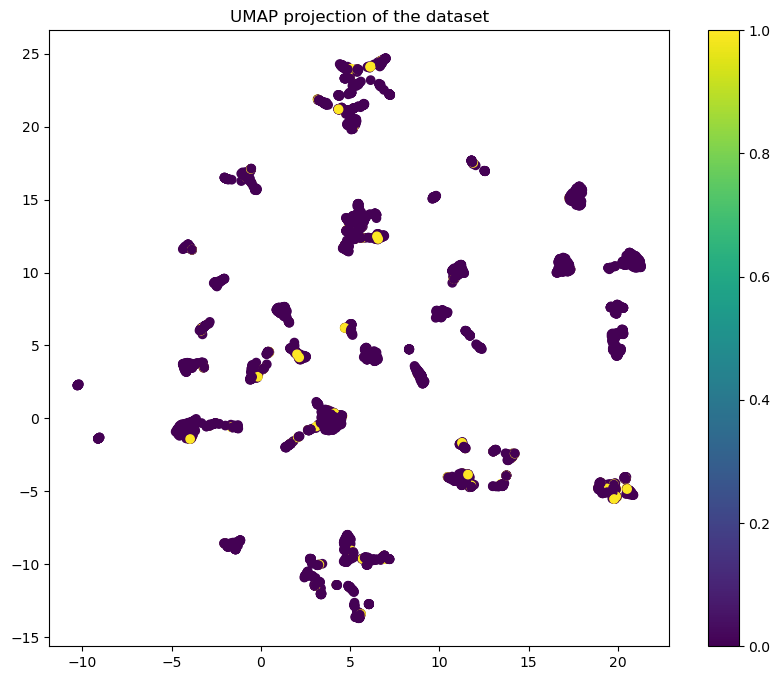

UMAP projection saved as 'umap_projection.png'


In [25]:
%matplotlib inline

import umap.umap_ as umap  # Ensure you're importing from umap_learn
import matplotlib.pyplot as plt
import os

# Correct file path handling
os.chdir(r'C:\Users\vk211\Desktop\Semester_3\DPA\project\CSP_571_Project')  # Use raw string or replace backslashes

# UMAP dimensionality reduction
reducer = umap.UMAP(random_state=42, n_jobs=1)
embedding = reducer.fit_transform(X_train_scaled)

# Plot UMAP projection
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=y_train, cmap='viridis')
plt.colorbar(scatter)
plt.title('UMAP projection of the dataset')

# Save the plot and display it
# plt.savefig('umap_projection.png')
plt.show()  # Ensure this is called to display the plot in Jupyter Notebook

print("UMAP projection saved as 'umap_projection.png'")


C:\Users\vk211\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


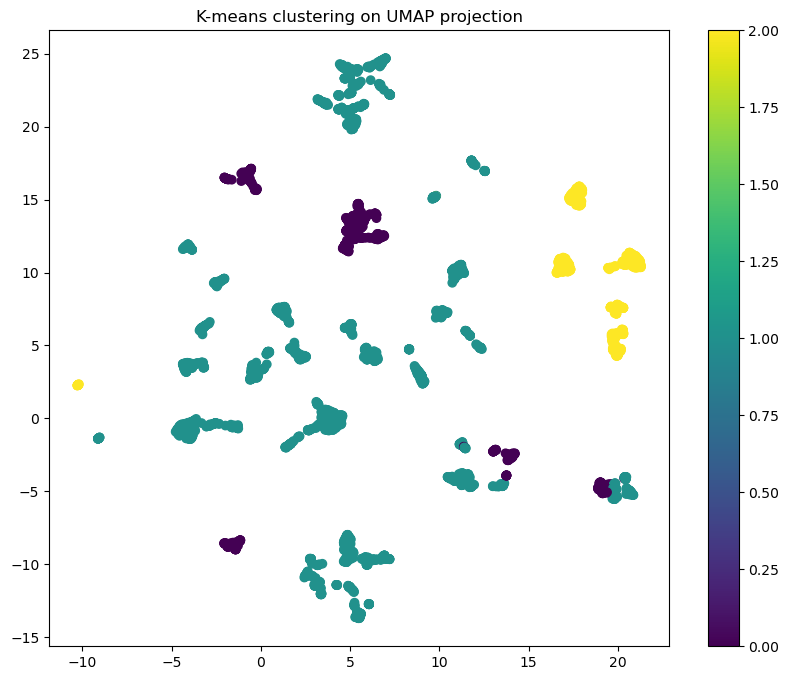

In [26]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_train_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap='viridis')
plt.colorbar(scatter)
plt.title('K-means clustering on UMAP projection')
plt.show()

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model = LogisticRegression(random_state=42)

cv_scores = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'auc': []
}

for train_idx, val_idx in cv.split(X_train_scaled, y_train):
    X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_val_fold)
    y_pred_proba = model.predict_proba(X_val_fold)[:, 1]
    
    cv_scores['accuracy'].append(accuracy_score(y_val_fold, y_pred))
    cv_scores['precision'].append(precision_score(y_val_fold, y_pred))
    cv_scores['recall'].append(recall_score(y_val_fold, y_pred))
    cv_scores['auc'].append(roc_auc_score(y_val_fold, y_pred_proba))

for metric, scores in cv_scores.items():
    print(f"Mean {metric}: {np.mean(scores):.3f} (+/- {np.std(scores):.3f})")

Mean accuracy: 0.955 (+/- 0.001)
Mean precision: 0.200 (+/- 0.400)
Mean recall: 0.005 (+/- 0.011)
Mean auc: 0.835 (+/- 0.012)


C:\Users\vk211\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vk211\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vk211\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vk211\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision 

In [28]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best AUC score:", grid_search.best_score_)

C:\Users\vk211\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\vk211\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\vk211\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\vk211\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\vk211\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\vk211\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

Best parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Best AUC score: 0.8388325128614232


C:\Users\vk211\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\vk211\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [29]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test Precision:", precision_score(y_test, y_pred))
print("Test Recall:", recall_score(y_test, y_pred))
print("Test AUC:", roc_auc_score(y_test, y_pred_proba))


Test Accuracy: 0.9393346379647749
Test Precision: 0.0
Test Recall: 0.0
Test AUC: 0.8534442204301075


C:\Users\vk211\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
